In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings

In [2]:
#Raw csv file from Github
news_data = "https://raw.githubusercontent.com/ml-truth-serum/fake_or_real_news/main/Resources/Data/news-jl.csv"

# Read File
news_df = pd.read_csv(news_data, header=0, encoding='utf-8')
# Display sample data
news_df.head(10)

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


## Step 1 - Clean the data

In [3]:
#check count of all rows
news_df.describe()

,id,title,text,label
count,7576,7185,6929,6755
unique,7531,7085,6644,437
top,#NAME?,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,16,5,58,3161


In [4]:
#drop NAs from all rows
news_df = news_df.dropna()


In [5]:
news_df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
#recheck all rows
news_df.describe()

,id,title,text,label
count,6754,6754,6754,6754
unique,6736,6667,6472,436
top,#NAME?,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,9,5,58,3161


In [7]:
#see datatype
news_df.dtypes

id       object
title    object
text     object
label    object
dtype: object

In [8]:
# Changing the data type of 'id' to float

news_df['id'] = pd.to_numeric(news_df['id'], errors='coerce')

# Using .loc to modify the 'id' column
# news_df_cleaned.loc[:, 'id'] = pd.to_numeric(news_df_cleaned['id'], errors='coerce')


In [9]:
news_df.dtypes

id       float64
title     object
text      object
label     object
dtype: object

In [10]:
# Changing the data type of 'title' 'text' 'label' to string

# news_df['title'] = news_df['title'].astype(str)
# news_df['text'] = news_df['text'].astype(str)
# news_df['label'] = news_df['label'].astype(str)

news_df = news_df.astype(dtype={'title': 'string', 'text': 'string', 'label': 'string'})


In [11]:
news_df.head()

,id,title,text,label
0,8476.0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294.0,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608.0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142.0,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875.0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
news_df.dtypes

id       float64
title     string
text      string
label     string
dtype: object

In [13]:
#drop the id column
revise_news_df = news_df.loc[:,["title", "text", "label"]]
revise_news_df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Step 2 - Get the columns that we need by transforming the columns

In [14]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.1 MB/s eta 0:00:00


In [15]:
import unidecode
import re, string

filter_df = pd.DataFrame(revise_news_df)

# Define the clean_text function
def clean_text(input_text):
    # 1. Change text to lower case
    final_text = input_text.lower()
    final_text = unidecode.unidecode(final_text)

    # 2. Remove digits
    final_text = re.sub(r'\d+', '', final_text)

    # 3. Remove punctuation, excluding apostrophes
    exclude = set(string.punctuation) - set("'")
    final_text = ''.join(ch for ch in final_text if ch not in exclude)
    #4 return the value
    return final_text

In [16]:
# Apply the clean_text function to the 'title' and 'text' columns
filter_df['title'] = filter_df['title'].apply(clean_text)
filter_df['text'] = filter_df['text'].apply(clean_text)

filter_df.head()

,title,text,label
0,you can smell hillary's fear,daniel greenfield a shillman journalism fellow...,FAKE
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry to go to paris in gesture of sympathy,us secretary of state john f kerry said monday...,REAL
3,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november the lesson ...,FAKE
4,the battle of new york why this primary matters,it's primary day in new york and frontrunners ...,REAL


In [17]:
# Splitting the 'TextColumn' for each row based on whitespace
filter_df['title_array'] = filter_df['title'].apply(lambda x: x.split())
filter_df['text_array'] = filter_df['text'].apply(lambda x: x.split())

# Drop duplicate words for each row
filter_df['title_array'] = filter_df['title_array'].apply(lambda x: np.unique(x))
filter_df['text_array'] = filter_df['text_array'].apply(lambda x: np.unique(x))

# Only grab the label and the new array columns
transform_array_df = filter_df[['label','title_array', 'text_array']]

transform_array_df.head()

,label,title_array,text_array
0,FAKE,"[can, fear, hillary's, smell, you]","[a, abedin, about, abuses, accused, accusing, ..."
1,FAKE,"[a, at, committed, exact, moment, paul, politi...","['s, a, abc, abcpolitics, about, aboutface, ad..."
2,REAL,"[gesture, go, in, kerry, of, paris, sympathy, to]","[a, about, abroad, act, address, affairs, afte..."
3,FAKE,"['we, against, anger, bernie, dnc, erupt, in, ...","[a, about, according, account, activist, adama..."
4,REAL,"[battle, matters, new, of, primary, the, this,...","[a, about, all, also, and, are, aren't, avoidi..."


In [18]:
#join array together

join_array_df = transform_array_df.loc[:,["label"]]

# Combine the arrays from both columns into a single array
join_array_df['combo_array'] = transform_array_df.apply(lambda row: np.concatenate([row['title_array'], row['text_array']]), axis=1)


join_array_df.head()

,label,combo_array
0,FAKE,"[can, fear, hillary's, smell, you, a, abedin, ..."
1,FAKE,"[a, at, committed, exact, moment, paul, politi..."
2,REAL,"[gesture, go, in, kerry, of, paris, sympathy, ..."
3,FAKE,"['we, against, anger, bernie, dnc, erupt, in, ..."
4,REAL,"[battle, matters, new, of, primary, the, this,..."


### Title and Label Columns ONLY

In [19]:
# Expand only the title array into new columns
title_expand_array_df = transform_array_df.loc[:, ["label"]]

# Create new columns for each element in the arrays
title_array_columns = pd.DataFrame(transform_array_df['title_array'].tolist(), dtype='string')

# Concatenate the new columns with the original DataFrame
title_expand_array_df = pd.concat([title_expand_array_df, title_array_columns], axis=1)

# Fill in NA with "NA"
title_expand_array_df = title_expand_array_df.fillna("NA")

# Display the DataFrame
title_expand_array_df.head()

,label,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,FAKE,can,fear,hillary's,smell,you,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,FAKE,a,at,committed,exact,moment,paul,political,rally,ryan,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,REAL,gesture,go,in,kerry,of,paris,sympathy,to,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,FAKE,'we,against,anger,bernie,dnc,erupt,in,on,supporters,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,REAL,battle,matters,new,of,primary,the,this,why,york,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [20]:
title_expand_array_df.dtypes

label    string
0        string
1        string
2        string
3        string
          ...  
67       string
68       string
69       string
70       string
71       string
Length: 73, dtype: object

### Text and Label Columns ONLY

In [21]:
#expand only the title array into new columns
text_expand_array_df = transform_array_df.loc[:,["label"]]

# Create new columns for each element in the arrays
text_array_columns = pd.DataFrame(transform_array_df['text_array'].tolist(), dtype='string')

# Concatenate the new columns with the original DataFrame
text_expand_array_df = pd.concat([text_expand_array_df, text_array_columns], axis=1)

#fill in na to "none"
text_expand_array_df = text_expand_array_df.fillna("NA")

text_expand_array_df.head()

,label,0,1,2,3,4,5,6,7,8,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,FAKE,a,abedin,about,abuses,accused,accusing,act,admits,ads,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,FAKE,'s,a,abc,abcpolitics,about,aboutface,ad,after,afternoon,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,REAL,a,about,abroad,act,address,affairs,after,against,am,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,FAKE,a,about,according,account,activist,adamant,against,all,almost,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,REAL,a,about,all,also,and,are,aren't,avoiding,be,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Combo(text and title) and Label Columns ONLY

In [22]:
#expand only the combo array into new columns
combo_expand_array_df = join_array_df.loc[:,["label"]]

# Create new columns for each element in the arrays and this keep the dtype as an object for each column
# combo_array_columns = join_array_df['combo_array'].apply(lambda x: pd.Series(x, dtype='object'))

# Create new columns for each element in the arrays and this keep the dtype as an STRING for each column
combo_array_columns = pd.DataFrame(join_array_df['combo_array'].tolist(), dtype='string')


# Concatenate the new columns with the original DataFrame
combo_expand_array_df = pd.concat([combo_expand_array_df, combo_array_columns], axis=1)

#fill in na to "none"
combo_expand_array_df = combo_expand_array_df.fillna("")

combo_expand_array_df.head()

,label,0,1,2,3,4,5,6,7,8,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,FAKE,can,fear,hillary's,smell,you,a,abedin,about,abuses,...,,,,,,,,,,
1,FAKE,a,at,committed,exact,moment,paul,political,rally,ryan,...,,,,,,,,,,
2,REAL,gesture,go,in,kerry,of,paris,sympathy,to,a,...,,,,,,,,,,
3,FAKE,'we,against,anger,bernie,dnc,erupt,in,on,supporters,...,,,,,,,,,,
4,REAL,battle,matters,new,of,primary,the,this,why,york,...,,,,,,,,,,


In [23]:
combo_expand_array_df.dtypes

label    string
0        string
1        string
2        string
3        string
          ...  
2019     string
2020     string
2021     string
2022     string
2023     string
Length: 2025, dtype: object

## Step 2 - prep data to be trained

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# Drop 'label' column for X and assign 'label' column to y
X = combo_expand_array_df.drop('label', axis=1)
y = combo_expand_array_df['label']

# Create a column transformer with a pipeline for one-hot encoding each column
transformers = []

for i in range(len(X.columns)):
    transformers.append((str(i), Pipeline([('onehot', OneHotEncoder())]), [i]))

ct = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Fit and transform X
X_transformed = ct.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=1/3, random_state=0)

In [25]:
print(X)

              0           1           2          3         4         5     \
0              can        fear   hillary's      smell       you         a   
1                a          at   committed      exact    moment      paul   
2          gesture          go          in      kerry        of     paris   
3              'we     against       anger     bernie       dnc     erupt   
4           battle     matters         new         of   primary       the   
...            ...         ...         ...        ...       ...       ...   
6554       clinton  convention  democratic  following      poll    spikes   
6556             a       again    campaign    florida     focus        in   
6558  conservative     house's         new  politburo       the         a   
6560       bizarre       drone        over    records  speeding     trees   
6561      energies         for      higher    prepare       the  yourself   

           6           7           8            9     ... 2014 2015 2016 20

In [26]:
print(y)

0       FAKE
1       FAKE
2       REAL
3       FAKE
4       REAL
        ... 
6554        
6556        
6558        
6560        
6561        
Name: label, Length: 7764, dtype: string


### Feature Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
print(X_train)

  (0, 990)	24.00235098764742
  (0, 2699)	50.882220731294005
  (0, 4813)	71.95137381062794
  (0, 7308)	71.95137381062794
  (0, 9979)	50.882220731294005
  (0, 13256)	22.772833282963347
  (0, 15900)	71.95137381062794
  (0, 18837)	71.95137381062794
  (0, 21428)	21.715146425127298
  (0, 24241)	71.95137381062794
  (0, 26404)	6.185871471594609
  (0, 26835)	50.882220731294005
  (0, 28855)	3.9513522702814625
  (0, 30646)	35.98611917663816
  (0, 32342)	4.8428958546826575
  (0, 33993)	50.882220731294005
  (0, 35504)	7.528227564322036
  (0, 36995)	12.757594633778478
  (0, 38554)	24.00235098764742
  (0, 40242)	50.882220731294005
  (0, 41770)	6.366900084417069
  (0, 43388)	50.882220731294005
  (0, 44908)	27.21084206076127
  (0, 46575)	6.5396085676919204
  (0, 48250)	9.266303725061752
  :	:
  (5175, 1215869)	71.95137381062794
  (5175, 1215873)	71.95137381062794
  (5175, 1215877)	71.95137381062794
  (5175, 1215881)	71.95137381062794
  (5175, 1215885)	71.95137381062794
  (5175, 1215889)	71.951373810627

In [29]:
print(X_test)

  (0, 820)	4.458467133396166
  (0, 2415)	50.882220731294005
  (0, 4670)	11.5639759900176
  (0, 7324)	32.190075596850676
  (0, 9970)	71.95137381062794
  (0, 12902)	22.772833282963347
  (0, 16018)	1.0
  (0, 18710)	35.98611917663816
  (0, 21517)	1.0
  (0, 24057)	1.0
  (0, 26300)	50.882220731294005
  (0, 28371)	1.0
  (0, 30178)	13.881964826361997
  (0, 31982)	32.190075596850676
  (0, 32111)	1.0
  (0, 33743)	1.0
  (0, 35284)	1.0
  (0, 36780)	71.95137381062794
  (0, 38380)	10.22397937176634
  (0, 39989)	1.0
  (0, 41531)	13.881964826361997
  (0, 43088)	29.388225996277022
  (0, 44664)	19.254012512756095
  (0, 46372)	8.057116885527806
  (0, 48028)	13.633142772764538
  :	:
  (2587, 1215869)	71.95137381062794
  (2587, 1215873)	71.95137381062794
  (2587, 1215877)	71.95137381062794
  (2587, 1215881)	71.95137381062794
  (2587, 1215885)	71.95137381062794
  (2587, 1215889)	71.95137381062794
  (2587, 1215893)	71.95137381062794
  (2587, 1215896)	71.95137381062794
  (2587, 1215899)	71.95137381062794
  (2

### Training the Logistic Regression model on the Training set

In [30]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Predicting the Test set results

In [31]:
# Make predictions on the test set
y_pred = classifier.predict(X_test)

### Making the Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  4   0   0 ... 176 161   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   1   0   0]
 ...
 [  6   0   0 ... 616 420   0]
 [  8   0   0 ... 630 425   0]
 [  0   0   0 ...   0   1   0]]


0.4037867078825348

### Visualising the results

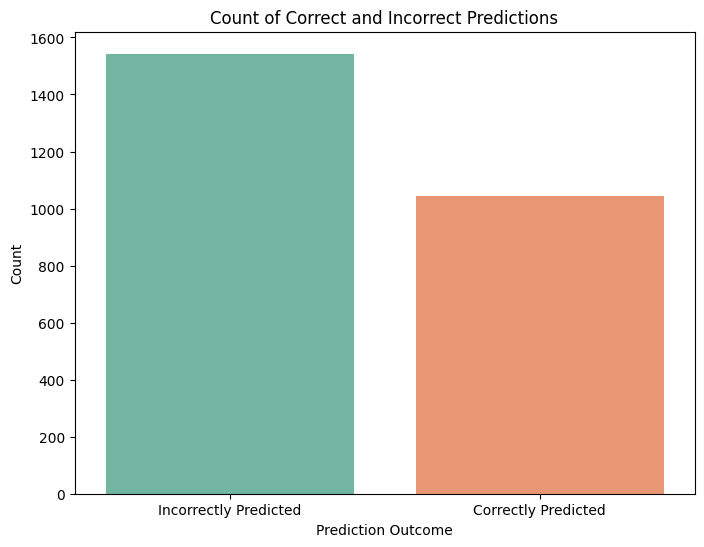

Accuracy: 40.38%


In [33]:
import seaborn as sns
# Create a DataFrame with actual and predicted labels
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create a confusion matrix
conf_matrix = confusion_matrix(results_df['Actual'], results_df['Predicted'])

# Map the actual and predicted labels to "Correctly Predicted" and "Incorrectly Predicted"
results_df['Outcome'] = results_df.apply(lambda row: 'Correctly Predicted' if row['Actual'] == row['Predicted'] else 'Incorrectly Predicted', axis=1)

# Plot the count of correct and incorrect predictions
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=results_df, palette='Set2')

plt.title('Count of Correct and Incorrect Predictions')
plt.xlabel('Prediction Outcome')
plt.ylabel('Count')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')